In [1]:
import collections
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm

## Load the Dataset

In [2]:
data_dir = '../data/N2C2-Track3-May3/'
train_fpath = os.path.join(data_dir, 'train.csv')
dev_fpath = os.path.join(data_dir, 'dev.csv')

In [3]:
df_train = pd.read_csv(train_fpath, low_memory=False)
print(f'{len(df_train)} train examples')
df_train.head()

4633 train examples


,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# CORONARIES: Patient with 3 vessel disease on...,Direct
1,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# Acute on Chronic systolic CHF: Patient with ...,Indirect
2,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# Social stressors: Recently lost mother to ca...,Neither
3,701359,186454,"51 yr old F with a history of 3V CAD, confirme...","# FEN: Replete lytes PRN, NPO for CABG today\n...",Not Relevant
4,554144,196435,"CHRONIC OBSTRUCTIVE PULMONARY DISEASE (COPD, B...",# Dyspnea: Differential in this patient would ...,Direct


In [4]:
df_dev = pd.read_csv(dev_fpath, low_memory=False)
print(f'{len(df_dev)} train examples')
df_dev.head()

597 train examples


,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,576487,112508,A 60 year old woman with recurrent ALL with CN...,"CNS VRE: S/P Omaya removal, on linezolid for ...",Direct
1,576487,112508,A 60 year old woman with recurrent ALL with CN...,LEUKOCYTOSIS: GCSF vs culture negative bacte...,Direct
2,576487,112508,A 60 year old woman with recurrent ALL with CN...,ALL: Currently day +43 s/p hyper-CVAD. She i...,Indirect
3,576487,112508,A 60 year old woman with recurrent ALL with CN...,DRUG RASH: Appears improved today. Evidence ...,Indirect
4,576487,112508,A 60 year old woman with recurrent ALL with CN...,ELEVATED LIVER ENZYMES: Consistent with shock...,Neither


## BERT Tokenizer

In [5]:
# Display the first example inputs
assess = df_train.iloc[0]['Assessment']
plan = df_train.iloc[0]['Plan Subsection']

print(f'Assessment: {len(assess.split())} words\n{assess}')
print()
print(f'Plan: {len(plan.split())} words\n{plan}')

Assessment: 41 words
51 yr old F with a history of 3V CAD, confirmed on C. cath during this
   admission, EF of 40%, who is transferred to CCU for monitoring of
   recurrent chest pain. Plan for CABG today to revascularize due to
   3-vessel disease.

Plan: 100 words
# CORONARIES: Patient with 3 vessel disease on cath. Previously found
   to be the case in [**2174**], but had been treated medically. On the floor,
   patient with recurrent chest pain and EKG changes, concerning for
   further ischemia. Chest pain has been controlled on nitro gtt. Patient
   in CCU for monitoring; plan for CABG today.
   - continue nitro gtt
   - if has further CP, would uptitrate nitro, and contact [**Name2 (NI) 9339**] and
   attending for potential balloon pump vs. urgent CABG
   - appreciate CT [**Doctor First Name 91**] recs
   - continue [**Last Name (LF) **], [**First Name3 (LF) 119**], ACE-i, simvastatin


In [6]:
# Clinical BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
print(f'Vocab {tokenizer.vocab_size} words')

Vocab 28996 words


In [7]:
tokenizer(assess)

{'input_ids': [101, 4062, 194, 1197, 1385, 175, 1114, 170, 1607, 1104, 124, 1964, 11019, 1181, 117, 3659, 1113, 172, 119, 5855, 1324, 1219, 1142, 10296, 117, 174, 2087, 1104, 1969, 110, 117, 1150, 1110, 3175, 1106, 14402, 1358, 1111, 9437, 1104, 1231, 21754, 2229, 2489, 119, 2197, 1111, 10347, 1403, 2052, 1106, 1231, 11509, 11702, 3708, 1496, 1106, 124, 118, 5832, 3653, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
print([tokenizer.decode([t]) for t in tokenizer.encode(assess, add_special_tokens=False)])

['51', 'y', '##r', 'old', 'f', 'with', 'a', 'history', 'of', '3', '##v', 'ca', '##d', ',', 'confirmed', 'on', 'c', '.', 'cat', '##h', 'during', 'this', 'admission', ',', 'e', '##f', 'of', '40', '%', ',', 'who', 'is', 'transferred', 'to', 'cc', '##u', 'for', 'monitoring', 'of', 're', '##current', 'chest', 'pain', '.', 'plan', 'for', 'cab', '##g', 'today', 'to', 're', '##vas', '##cular', '##ize', 'due', 'to', '3', '-', 'vessel', 'disease', '.']


In [9]:
wordpiece_cnt = len([tokenizer.decode([t]) for t in tokenizer.encode(assess, add_special_tokens=False)])
print(f'{wordpiece_cnt} wordpieces')

61 wordpieces


## Dataset Statistics

- HADM_ID / ROW_ID counts

In [10]:
print(f'Train examples: {len(df_train)}')
print(f'Train unique HADM IDs: {len(df_train["HADM ID"].unique())}')
print(f'Train unique ROW IDs: {len(df_train["ROW ID"].unique())}')
print()
print(f'Dev examples: {len(df_dev)}')
print(f'Dev unique HADM IDs: {len(df_dev["HADM ID"].unique())}')
print(f'Dev unique ROW IDs: {len(df_dev["ROW ID"].unique())}')

Train examples: 4633
Train unique HADM IDs: 598
Train unique ROW IDs: 598

Dev examples: 597
Dev unique HADM IDs: 75
Dev unique ROW IDs: 75


- Input length analysis

In [11]:
get_word_count = lambda x: len(x.split())
get_wordpiece_count = lambda x: len(tokenizer.encode(x, add_special_tokens=False))

In [12]:
df_train['Assess_word_cnt'] = df_train['Assessment'].map(get_word_count)
df_train['Plan_word_cnt'] = df_train['Plan Subsection'].map(get_word_count)
df_train['Input_word_cnt'] = df_train['Assess_word_cnt'] + df_train['Plan_word_cnt']
df_train['Assess_wordpiece_cnt'] = df_train['Assessment'].map(get_wordpiece_count)
df_train['Plan_wordpiece_cnt'] = df_train['Plan Subsection'].map(get_wordpiece_count)
df_train['Input_wordpiece_cnt'] = df_train['Assess_wordpiece_cnt'] + df_train['Plan_wordpiece_cnt']
df_train.head()

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation,Assess_word_cnt,Plan_word_cnt,Input_word_cnt,Assess_wordpiece_cnt,Plan_wordpiece_cnt,Input_wordpiece_cnt
0,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# CORONARIES: Patient with 3 vessel disease on...,Direct,41,100,141,61,185,246
1,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# Acute on Chronic systolic CHF: Patient with ...,Indirect,41,59,100,61,103,164
2,701359,186454,"51 yr old F with a history of 3V CAD, confirme...",# Social stressors: Recently lost mother to ca...,Neither,41,21,62,61,29,90
3,701359,186454,"51 yr old F with a history of 3V CAD, confirme...","# FEN: Replete lytes PRN, NPO for CABG today\n...",Not Relevant,41,69,110,61,170,231
4,554144,196435,"CHRONIC OBSTRUCTIVE PULMONARY DISEASE (COPD, B...",# Dyspnea: Differential in this patient would ...,Direct,31,178,209,68,293,361


In [13]:
df_dev['Assess_word_cnt'] = df_dev['Assessment'].map(get_word_count)
df_dev['Plan_word_cnt'] = df_dev['Plan Subsection'].map(get_word_count)
df_dev['Input_word_cnt'] = df_dev['Assess_word_cnt'] + df_dev['Plan_word_cnt']
df_dev['Assess_wordpiece_cnt'] = df_dev['Assessment'].map(get_wordpiece_count)
df_dev['Plan_wordpiece_cnt'] = df_dev['Plan Subsection'].map(get_wordpiece_count)
df_dev['Input_wordpiece_cnt'] = df_dev['Assess_wordpiece_cnt'] + df_dev['Plan_wordpiece_cnt']
df_dev.head()

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation,Assess_word_cnt,Plan_word_cnt,Input_word_cnt,Assess_wordpiece_cnt,Plan_wordpiece_cnt,Input_wordpiece_cnt
0,576487,112508,A 60 year old woman with recurrent ALL with CN...,"CNS VRE: S/P Omaya removal, on linezolid for ...",Direct,38,57,95,59,114,173
1,576487,112508,A 60 year old woman with recurrent ALL with CN...,LEUKOCYTOSIS: GCSF vs culture negative bacte...,Direct,38,32,70,59,59,118
2,576487,112508,A 60 year old woman with recurrent ALL with CN...,ALL: Currently day +43 s/p hyper-CVAD. She i...,Indirect,38,43,81,59,89,148
3,576487,112508,A 60 year old woman with recurrent ALL with CN...,DRUG RASH: Appears improved today. Evidence ...,Indirect,38,12,50,59,19,78
4,576487,112508,A 60 year old woman with recurrent ALL with CN...,ELEVATED LIVER ENZYMES: Consistent with shock...,Neither,38,12,50,59,20,79


In [14]:
df_train.describe()

,ROW ID,HADM ID,Assess_word_cnt,Plan_word_cnt,Input_word_cnt,Assess_wordpiece_cnt,Plan_wordpiece_cnt,Input_wordpiece_cnt
count,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000
mean,514815.716382,156080.584071,34.248219,43.722210,77.970430,66.944528,83.301964,150.246493
std,130212.618574,39831.401842,16.893145,38.007412,41.955382,34.862488,70.684894,79.148505
min,315721.000000,100215.000000,7.000000,1.000000,13.000000,13.000000,2.000000,23.000000
25%,394985.000000,109598.000000,24.000000,17.000000,47.000000,44.000000,31.000000,91.000000
50%,508492.000000,184208.000000,31.000000,33.000000,69.000000,60.000000,62.000000,132.000000
75%,633441.000000,192715.000000,41.000000,60.000000,98.000000,82.000000,116.000000,191.000000
max,738065.000000,199948.000000,131.000000,339.000000,373.000000,233.000000,607.000000,673.000000


In [15]:
df_dev.describe()

,ROW ID,HADM ID,Assess_word_cnt,Plan_word_cnt,Input_word_cnt,Assess_wordpiece_cnt,Plan_wordpiece_cnt,Input_wordpiece_cnt
count,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000
mean,531920.278057,150861.075377,37.336683,40.192630,77.529313,74.030151,77.664992,151.695142
std,126458.715842,40241.764493,21.673884,41.207424,47.352398,45.109551,75.853057,89.365704
min,333961.000000,101382.000000,3.000000,3.000000,9.000000,9.000000,3.000000,19.000000
25%,409503.000000,106576.000000,22.000000,15.000000,47.000000,43.000000,28.000000,91.000000
50%,523940.000000,149711.000000,34.000000,30.000000,66.000000,64.000000,56.000000,132.000000
75%,660112.000000,188204.000000,43.000000,54.000000,96.000000,88.000000,107.000000,193.000000
max,734680.000000,199779.000000,122.000000,527.000000,553.000000,228.000000,960.000000,994.000000


<AxesSubplot:xlabel='Dev Total Wordpiece', ylabel='Count'>

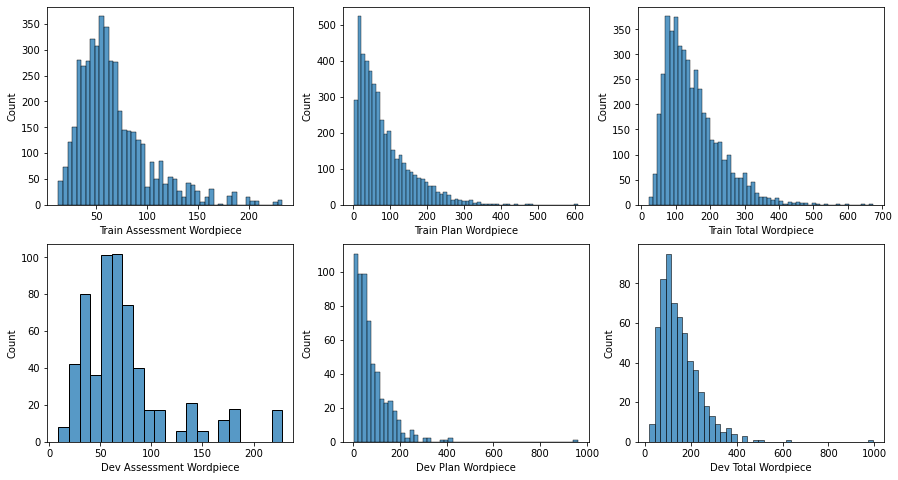

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.xlabel('Train Assessment Wordpiece')
sns.histplot(df_train['Assess_wordpiece_cnt'])
plt.subplot(2, 3, 2)
plt.xlabel('Train Plan Wordpiece')
sns.histplot(df_train['Plan_wordpiece_cnt'])
plt.subplot(2, 3, 3)
plt.xlabel('Train Total Wordpiece')
sns.histplot(df_train['Input_wordpiece_cnt'])

plt.subplot(2, 3, 4)
plt.xlabel('Dev Assessment Wordpiece')
sns.histplot(df_dev['Assess_wordpiece_cnt'])
plt.subplot(2, 3, 5)
plt.xlabel('Dev Plan Wordpiece')
sns.histplot(df_dev['Plan_wordpiece_cnt'])
plt.subplot(2, 3, 6)
plt.xlabel('Dev Total Wordpiece')
sns.histplot(df_dev['Input_wordpiece_cnt'])

- Label analysis

In [17]:
# Train label stats
counter_train_lbl = collections.Counter(df_train['Relation'])
counter_train_lbl

Counter({'Direct': 1090,
         'Indirect': 1249,
         'Neither': 1484,
         'Not Relevant': 810})

In [18]:
# Dev label stats
counter_dev_lbl = collections.Counter(df_dev['Relation'])
counter_dev_lbl

Counter({'Direct': 145, 'Indirect': 179, 'Neither': 173, 'Not Relevant': 100})